In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm,tqdm_notebook
import nltk
import re
import time

# gensim显示训练进度
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#不显示警告
import warnings
warnings.filterwarnings("ignore")

# 读取数据

In [2]:
df_trainL=pd.read_csv('word2vec-nlp-tutorial/labeledTrainData.tsv',sep='\t+')
df_trainUL=pd.read_csv('word2vec-nlp-tutorial/unlabeledTrainData.tsv',sep='\t+')
df_test=pd.read_csv('word2vec-nlp-tutorial/testData.tsv',sep='\t+')

三个数据的基本信息

In [3]:
df_trainL.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
df_trainUL.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [5]:
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
# 数据量
df_trainL.shape,df_trainUL.shape,df_test.shape

((25000, 3), (50000, 2), (25000, 2))

# 数据预处理

训练集和测试集的数据清洗。这部分进行的去标签，标点符号，正则化等

In [7]:
train_review_L=df_trainL['review']
train_review_UL=df_trainUL['review']
test_review=df_test['review']
labels=df_trainL['sentiment']

In [8]:
# URL格式的正则表达式
p_url = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+~]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
STEM = nltk.stem.PorterStemmer() #词干提取器
STOPW=nltk.corpus.stopwords.words('english') #英文停用词

def clean_text(corpus,stemming=False,symbol_remove=True):
    '''清洗原始文本的函数
    @stemming 是否词干化
    @symbol_remove 是否移除非英文和数字字符'''
    clean_corpus=[]
    for raw_text in tqdm_notebook(corpus,desc='文本处理中'): #遍历原始文本
        text=BeautifulSoup(raw_text).text #去掉网页标签
        text=p_url.sub('URL',text) #具体的链接替换为URL
        if symbol_remove: #正则去除非英文字符,变小写
            text=re.sub('[^\w]',' ',text).lower()

        wl=nltk.word_tokenize(text) #切分句子
        if stemming: #stem
            wl=map(lambda w:STEM.stem(w),wl) 

        wl=filter(lambda w:w not in STOPW,wl) #stopword
    
        clean_corpus.append(' '.join(wl))

    return clean_corpus


In [9]:
# clean_text函数测试
print('--- train_review_L 文本处理 ---')
train_review_L_clean=clean_text(train_review_L,stemming=True)

print('--- train_review_UL 文本处理 ---')
train_review_UL_clean=clean_text(train_review_UL,stemming=True)

print('--- test_review 文本处理 ---')
test_review_clean=clean_text(test_review,stemming=True)

--- train_review_L 文本处理 ---



--- train_review_UL 文本处理 ---



--- test_review 文本处理 ---


# 特征工程

BOW/TF-IDF/WORD2VEC三种特征工程方法 对比

In [10]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from gensim.models import word2vec

def get_vec(train_data,test_data,method='bow',MAX_FEATURES=200):
    '''功能：对原始语料库处理，获取特征向量
    @train_reviews 训练集的review文本
    @test_reviews  测试集的review文本
    @method 向量的获取方法 bow/tfidf/word2vec
    @MAX_FEATURES 向量维度'''
    
    corpus=train_data # corpus not include test_data 
    LABEL_SIZE=25000 #有标签的数量
    
    if method=='bow' or method=='tfidf':
        CV=CountVectorizer(max_features=MAX_FEATURES)
        TFIDF=TfidfTransformer()
        
        BOW=CV.fit(train_data) 
        if method=='bow':
            print('bow特征向量生成中...')
            train_vec=BOW.transform(train_data[:LABEL_SIZE]).toarray()
            test_vec=BOW.transform(test_data).toarray()
            print('bow特征向量生成ok')
            return train_vec,test_vec
        elif method=='tfidf':
            print('tfidf特征向量生成中...')
            # X=TFIDF.fit_transform(BOW)
            train_vec=TFIDF.fit_transform(BOW.transform(train_data[:LABEL_SIZE])).toarray()
            test_vec=TFIDF.fit_transform(BOW.transform(test_data)).toarray()
            print('tfidf特征向量生成ok')
            return train_vec,test_vec
    elif method=='word2vec':
        # gensim word2vec模型的输入要求是切分好的语料库
        print('word2vec特征向量生成中...')
        train_wl=list(map(lambda sent:nltk.word_tokenize(sent),train_data[:LABEL_SIZE]))
        test_wl=list(map(lambda sent:nltk.word_tokenize(sent),test_data))
        # 根据语料库训练word2vec模型
        model = word2vec.Word2Vec(train_wl, hs=1,min_count=1,sg=1,
                                  window=3,size=MAX_FEATURES)
        def get_wv(w):
            '''获取word2vec的词向量的函数'''
            try: 
                wv=model.wv.get_vector(w)
            except: # 找不到当前词的情况下，返回0向量，维度是MAX_FEATURES
                wv=np.array([0]*MAX_FEATURES)
            return wv
        
        
        train_vec,test_vec=[],[]
        
        # 句向量是词向量的mean
        for wl in tqdm(train_wl,desc='训练集向量生成中'):
            sent_vec=np.array(list(map(lambda w:get_wv(w),wl))).mean(0)
            train_vec.append(sent_vec)
        for wl in tqdm(test_wl,desc='测试集向量生成中'):
            sent_vec=np.array(list(map(lambda w:get_wv(w),wl))).mean(0)
            test_vec.append(sent_vec)
            
        train_vec,test_vec=np.array(train_vec),np.array(test_vec)
        print('word2vec特征向量生成ok')
        
        return train_vec,test_vec

2019-08-25 00:43:59,906 : INFO : 'pattern' package not found; tag filters are not available for English


语料库的选择方案: 
- 1.用labeledTrain+testData作为语料；
- 2.用labeledTrain+unlabeledTrain+testData作为语料；

In [11]:
# # 这里选择方案1 (用labeledTrain+testData作为语料)
# train_data=train_review_L_clean
# test_data=test_review_clean

# 这里选择方案2 (用labeledTrain+unlabeledTrain作为语料)
train_data=train_review_L_clean+train_review_UL_clean
test_data=test_review_clean

**1. 向量化-BOW**

In [12]:
bow_train,bow_test=get_vec(train_data,test_data,method='bow',MAX_FEATURES=200)

bow特征向量生成中...
bow特征向量生成ok


**2. 向量化-TFIDF**

In [13]:
tfidf_train,tfidf_test=get_vec(train_data,test_data,method='tfidf',MAX_FEATURES=200)

tfidf特征向量生成中...
tfidf特征向量生成ok


**3. 向量化-Word2Vec**

In [14]:
w2v_train,w2v_test=get_vec(train_data,test_data,method='word2vec',MAX_FEATURES=200)

word2vec特征向量生成中...


2019-08-25 00:44:53,527 : INFO : collecting all words and their counts
2019-08-25 00:44:53,528 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-08-25 00:44:53,789 : INFO : PROGRESS: at sentence #10000, processed 1312721 words, keeping 35738 word types
2019-08-25 00:44:54,046 : INFO : PROGRESS: at sentence #20000, processed 2610408 words, keeping 47423 word types
2019-08-25 00:44:54,183 : INFO : collected 52163 word types from a corpus of 3254843 raw words and 25000 sentences
2019-08-25 00:44:54,184 : INFO : Loading a fresh vocabulary
2019-08-25 00:44:54,497 : INFO : effective_min_count=1 retains 52163 unique words (100% of original 52163, drops 0)
2019-08-25 00:44:54,498 : INFO : effective_min_count=1 leaves 3254843 word corpus (100% of original 3254843, drops 0)
2019-08-25 00:44:54,648 : INFO : deleting the raw counts dictionary of 52163 items
2019-08-25 00:44:54,650 : INFO : sample=0.001 downsamples 39 most-common words
2019-08-25 00:44:54,652 : INFO : 

2019-08-25 00:45:47,928 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-25 00:45:47,929 : INFO : EPOCH - 4 : training on 3254843 raw words (2987563 effective words) took 13.2s, 227143 effective words/s
2019-08-25 00:45:48,943 : INFO : EPOCH 5 - PROGRESS: at 7.53% examples, 225345 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:49,954 : INFO : EPOCH 5 - PROGRESS: at 15.56% examples, 234292 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:51,008 : INFO : EPOCH 5 - PROGRESS: at 23.74% examples, 233354 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:52,042 : INFO : EPOCH 5 - PROGRESS: at 31.88% examples, 234241 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:53,077 : INFO : EPOCH 5 - PROGRESS: at 39.16% examples, 229491 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:54,116 : INFO : EPOCH 5 - PROGRESS: at 46.22% examples, 224821 words/s, in_qsize 5, out_qsize 0
2019-08-25 00:45:55,132 : INFO : EPOCH 5 - PROGRESS: at 53.61% examples, 224616 words/s, in_qs

word2vec特征向量生成ok


# 模型构建,拟合,评价

- 支持向量机，朴素贝叶斯，随机森林，xgboost，逻辑回归
- 系统评估指标(ROC，AUC，训练所需时间)

模型定义

In [20]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# 初始化各个分类器
svm_clf=SVC(max_iter=300,probability=True) #定义一个max_iter避免SVM拟合时间太长
nb_clf=GaussianNB() 
rf_clf=RandomForestClassifier()
xgb_clf=XGBClassifier()
lr_clf=LogisticRegression()

模型拟合和记录预测结果

k-fold+roc曲线资料  https://blog.csdn.net/lz_peter/article/details/78054914

Model【SVM】Process ...
data normalization ....


data normalization ....


data normalization ....


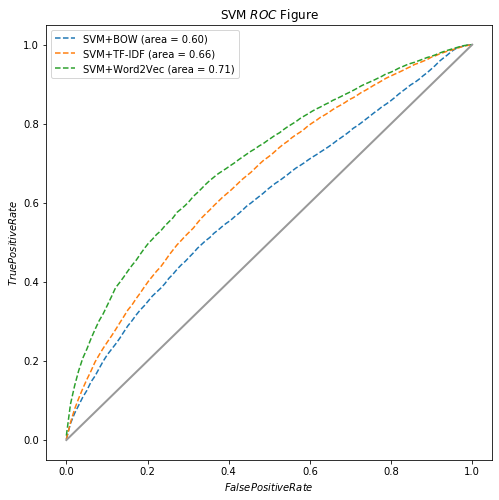

Model【Naive_bayes】Process ...


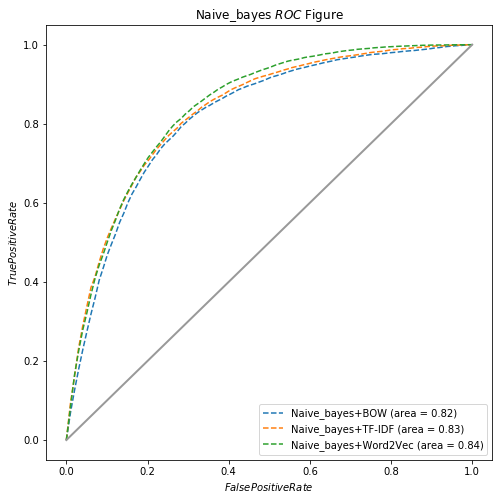

Model【RandomForest】Process ...


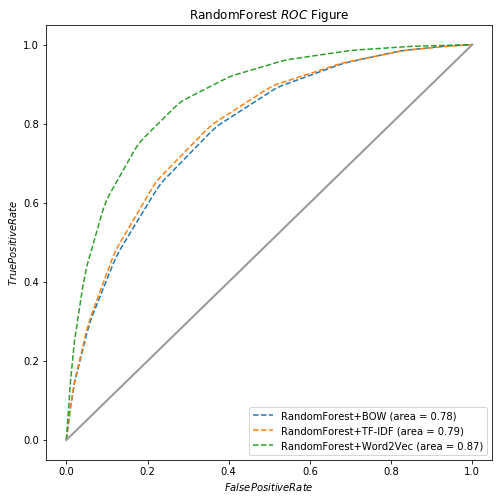

Model【LogisticRegression】Process ...
data normalization ....


data normalization ....


data normalization ....


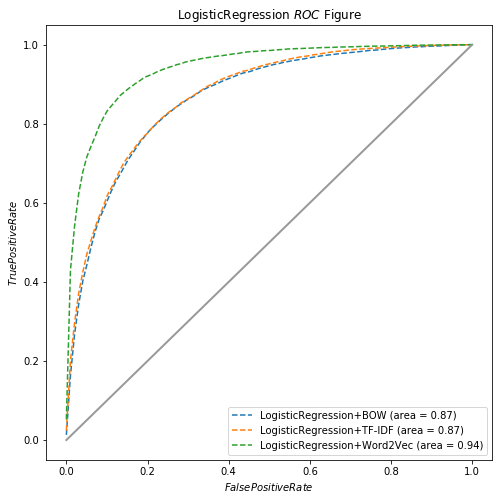

Model【Xgboost】Process ...


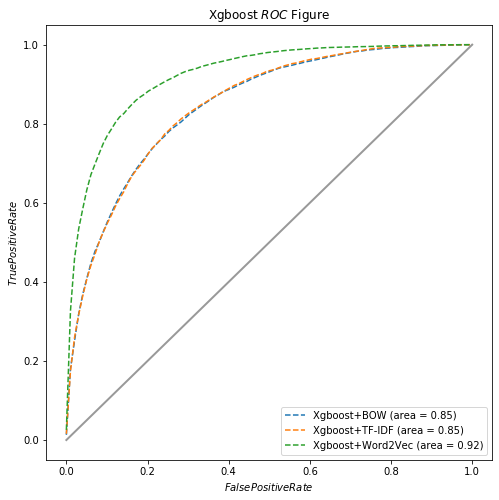

In [21]:
from sklearn.metrics import f1_score,auc,roc_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy import interp


# ------- 1. 选取的对比模型 -------（数据量太大，SVM非常慢，不建议用）
# MNAMES=['支持向量机','朴素贝叶斯','随机森林','xgboost','逻辑回归']
# MODELS=[svm_clf,nb_clf,rf_clf,xgb_clf,lr_clf]
MNAMES=['SVM','Naive_bayes','RandomForest','LogisticRegression','Xgboost']
MODELS=[svm_clf,nb_clf,rf_clf,lr_clf,xgb_clf]

# ------- 2. 选取的对比特征向量 -------
FNAMES=['BOW','TF-IDF','Word2Vec']
DATAS=[(bow_train,labels),(tfidf_train,labels),(w2v_train,labels)]


RNAMES=['f1','roc_auc','time'] #待测指标名


def evaluate(n_splits=5,plot_roc=True):
    '''评测模型
    @n_splits k-fold对折的次数，默认5，每次选20%的测试数据'''
    
    # 记录结果的dataframe
    df_eval=pd.DataFrame(np.zeros((len(MNAMES)*len(RNAMES),len(FNAMES))),
            index=pd.MultiIndex.from_product([MNAMES,RNAMES]),columns=FNAMES)
    
    
    for model_name,model in zip(MNAMES,MODELS): # 遍历每一个模型
        
        if plot_roc: #创建图形,每一个模型绘制一个ROC图像
            fig,axes=plt.subplots(1,1,figsize=(8,8))
        
        print('Model【%s】Process ...'%model_name)
        for feature_name,(X,y) in zip(FNAMES,DATAS):# 遍历每一种特征向量
            if model_name in ['LogisticRegression','SVM']: #进行数据归一化会降低评测速度,选择部分模型做归一化
                print('data normalization ....')
                X=StandardScaler().fit_transform(X) 
            #k-fold交叉验证
            kf=KFold(n_splits=n_splits,shuffle=False,random_state=0)
            all_pred,all_true,all_time=[],[],[]
            
            #roc参数存储
            mean_tpr=np.zeros(100)
            mean_fpr = np.linspace(0, 1, 100)
            
            for trainIdx,testIdx in tqdm_notebook(kf.split(X),total=n_splits,
                                                desc='featureVec %s CrossValid'%feature_name):
                X_train,X_test=X[trainIdx],X[testIdx]
                y_train,y_test=labels[trainIdx],labels[testIdx]
                
                Stime=time.time() #训练起始时间
                model.fit(X_train,y_train)
                time_elapse=time.time()-Stime #训练耗时
                
                # 模型预测
                y_pred=model.predict(X_test)
                y_pred_prob=model.predict_proba(X_test)
                
                # acc，time参数计算
                all_pred.extend(y_pred.tolist())
                all_true.extend(y_test.tolist())
                all_time.append(time_elapse)
                #roc参数计算
                fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:, 1])
                mean_tpr += interp(mean_fpr, fpr, tpr) #对mean_tpr在mean_fpr处进行插值
                
                
                
            mean_acc=f1_score(all_pred,all_true) #训练acc
            time_elapse=np.mean(all_time)# 训练时间
            #roc参数计算
            mean_tpr/=n_splits
            mean_auc = auc(mean_fpr, mean_tpr)
            
            if plot_roc: #绘制单个roc曲线
                plt.plot(mean_fpr, mean_tpr, '--',
                    label='%s+%s (area = %.2f)'%(model_name,feature_name,mean_auc))
            
                
            df_eval.loc[model_name,feature_name]=np.array([mean_acc,mean_auc,time_elapse])

        if plot_roc: #显示图形  
            plt.plot([0, 1], [0, 1], '-', color=(0.6, 0.6, 0.6), lw=2) #画对角线
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('$False Positive Rate$')
            plt.ylabel('$True Positive Rate$')
            plt.title('%s $ROC$ Figure'%model_name)
            plt.legend(loc="best")
            plt.show()

    return df_eval
        
df_eval=evaluate()

In [27]:
df_eval

BOW     TF-IDF   Word2Vec
SVM                f1        0.546374   0.586827   0.633272
                   roc_auc   0.603395   0.659539   0.706230
                   time     17.105490  16.823296  16.758291
Naive_bayes        f1        0.748868   0.761965   0.750206
                   roc_auc   0.818717   0.832016   0.840995
                   time      0.061125   0.050399   0.028582
RandomForest       f1        0.689088   0.697762   0.778787
                   roc_auc   0.783380   0.791519   0.866512
                   time      0.478644   0.925381   2.368244
LogisticRegression f1        0.792512   0.792950   0.869211
                   roc_auc   0.866084   0.871799   0.940076
                   time      0.368245   0.368548   0.731368
Xgboost            f1        0.771556   0.775096   0.845621
                   roc_auc   0.845856   0.846910   0.921187
                   time     17.112552  19.927858  32.821784

绘图对比各项指标

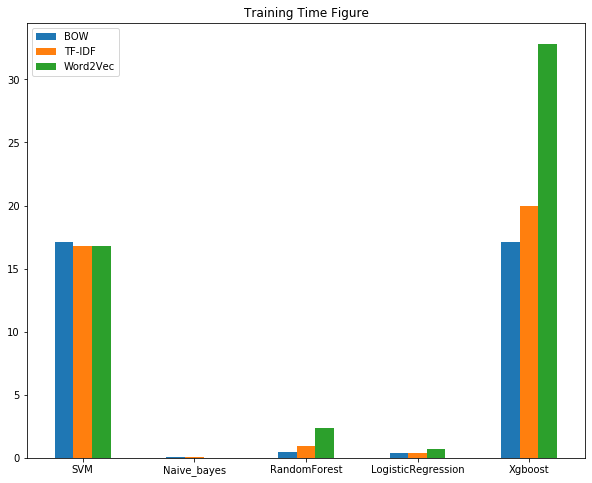

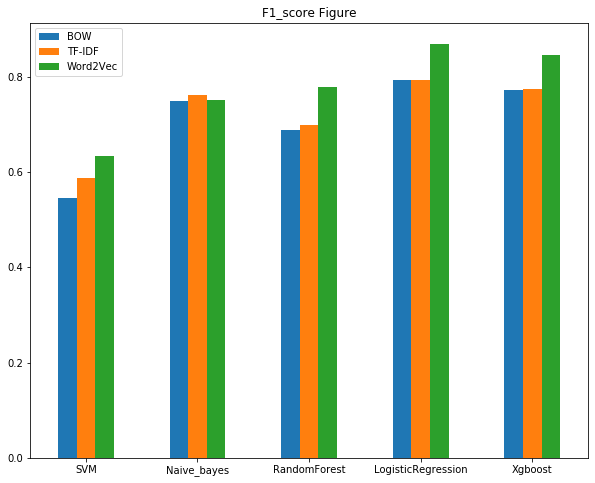

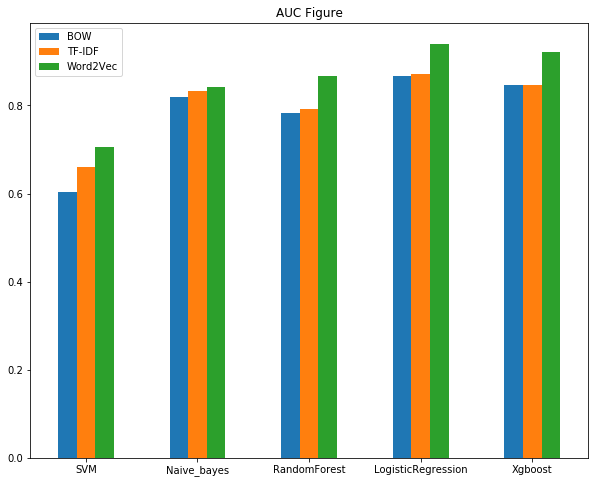

In [28]:
# 训练时间对比图
df_eval.loc[zip(MNAMES,['time']*len(MNAMES))].swaplevel().loc['time'].plot(
                                kind='bar',rot=0,title='Training Time Figure',figsize=(10,8))

# accuracy对比图
df_eval.loc[zip(MNAMES,['f1']*len(MNAMES))].swaplevel().loc['f1'].plot(
                                kind='bar',rot=0,title='F1_score Figure',figsize=(10,8))

# roc_auc对比图
df_eval.loc[zip(MNAMES,['roc_auc']*len(MNAMES))].swaplevel().loc['roc_auc'].plot(
                                kind='bar',rot=0,title='AUC Figure',figsize=(10,8))


利用模型预测测试集上数据

In [29]:
# 这里举个例子
model=lr_clf #选择逻辑回归模型
X_train,X_test=w2v_train,w2v_test #选择word2vec特征向量
y_train=labels #训练集上标签

# 拟合 预测
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

#结果整理到pandas表格中
df_pred=pd.DataFrame({'id':df_test['id'].map(lambda s:s.strip('""')),'sentiment':y_pred}) 
df_pred.head(10) #显示前10条


,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1
5,2913_8,1
6,4396_1,0
7,395_2,0
8,10616_1,0
9,9074_9,1


In [30]:
df_pred.to_csv('submit0825.csv',index=None) #存储到csv文件